# Lab 3. Deep Learning

## Miembros
- Fernanda Esquivel 21542
- Sofía Lam 21548

## Link al repositorio
El repositorio puede ser visualizado [acá](https://github.com/SofiLam13/Lab3-DataScience-.git)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [3]:
consumo = pd.read_csv('CONSUMO.csv')
importacion=pd.read_csv('IMPORTACION.csv')
PreciosPromedio=pd.read_csv('PreciosPromedio.csv')

# Primer modelo

## Consumo

In [4]:
consumo["Gasolina superior"] = consumo["Gasolina superior"].astype(str)
consumo["Gasolina superior"] = consumo["Gasolina superior"].apply(lambda x: x.replace(',', '')).astype(float)
consumo.head()

,Fecha,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petróleo,Gasolina de aviación,...,Kerosina,Mezclas\noleosas,Naftas,PetCoke,Petróleo crudo,Solventes,Butano,Diesel alto azufre,Orimulsión,Total
0,Jan-00,0,"48,446.00","296,766.99",0.0,0,0,0,"194,410.48","1,426.00",...,"64,026.09",0,0.0,0,0,0,0.0,"634,667.06",0,"1,750,544.64"
1,Feb-00,0,"50,597.00","328,116.44",0.0,0,0,0,"174,710.55","1,458.00",...,"62,660.30",0,0.0,0,0,0,0.0,"642,380.66",0,"1,773,220.22"
2,Mar-00,0,"27,593.00","368,589.63",0.0,0,0,0,"189,234.07","1,503.00",...,"61,361.99",0,0.0,0,0,0,0.0,"699,807.25",0,"1,909,498.79"
3,Apr-00,0,"53,794.00","396,300.47",0.0,0,0,0,"174,330.61","1,561.00",...,"61,814.32",0,0.0,0,0,0,0.0,"586,803.98",0,"1,800,932.86"
4,May-00,0,"60,137.00","449,368.92",0.0,0,0,0,"191,745.15","1,642.00",...,"54,098.32",0,0.0,0,0,0,0.0,"656,948.20",0,"1,941,771.90"


Pasamos la columna de fecha al formato de fecha para podeer realizar las series de tiempo correspondientes.

In [5]:
consumo['Fecha'] = pd.to_datetime(consumo['Fecha'],format='%b-%y', errors='coerce')

In [6]:
consumo.set_index('Fecha', inplace=True)

### Serie de tiempo consumo

In [7]:
consumoScaled = consumo['Gasolina superior'].resample('M').mean()

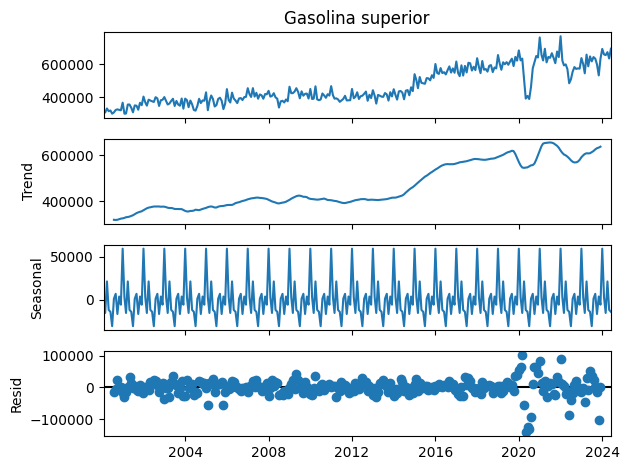

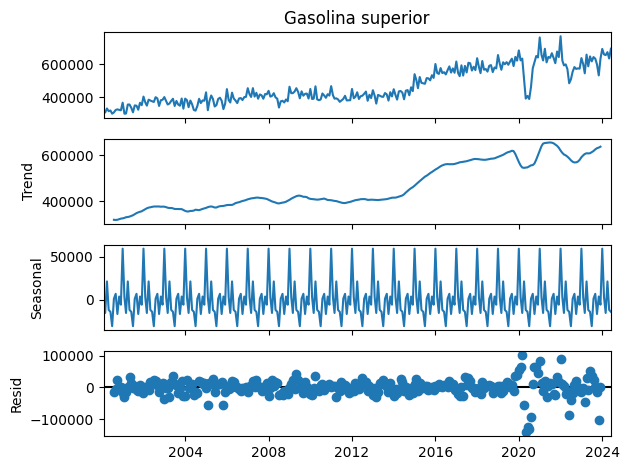

In [8]:
resultado_superiorC = seasonal_decompose(consumoScaled.dropna())
resultado_superiorC.plot()

### LSTM

In [9]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(consumoScaled, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.678783
p-value                        0.852169
# de retardos usados          12.000000
# de observaciones usadas    280.000000
Critical Value (1%)           -3.453922
Critical Value (5%)           -2.871918
Critical Value (10%)          -2.572300
dtype: float64


In [10]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
consumo_diff = consumoScaled.diff()
consumo_diff.fillna(0,inplace=True)
dfTest = adfuller(consumo_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.675884
p-value                        0.000093
# de retardos usados          16.000000
# de observaciones usadas    276.000000
Critical Value (1%)           -3.454267
Critical Value (5%)           -2.872070
Critical Value (10%)          -2.572381
dtype: float64


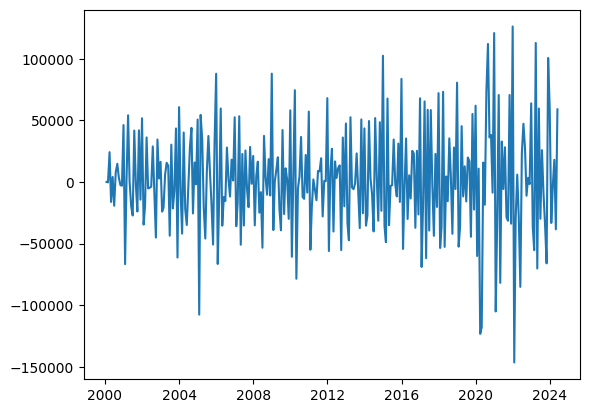

In [11]:
plt.plot(consumo_diff)

In [12]:
scaler = StandardScaler()
# Convertir la serie a un array de NumPy
consumo_diff_array = consumo_diff.values

# Reshape a 2D
consumo_diff_array = consumo_diff_array.reshape(-1, 1)
data_c = scaler.fit_transform(consumo_diff_array)

In [13]:
entrenamiento = round(0.6*len(data_c))
val_prueba = round(0.2*len(data_c))
test = data_c[(entrenamiento+val_prueba)-1:]
validation = data_c[(entrenamiento):entrenamiento+val_prueba+1]
train = data_c[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

59

In [14]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

xC_train,yC_train = supervisada(train)
xC_val,yC_val = supervisada(validation)
xC_test,yC_test = supervisada(test)


In [15]:
xC_train = np.reshape(xC_train,(xC_train.shape[0],1,1))
xC_val = np.reshape(xC_val, (xC_val.shape[0],1,1))
xC_test = np.reshape(xC_test, (xC_test.shape[0],1,1))
len(xC_val)

59

In [16]:
modelo1 = Sequential()
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada
modelo1.add(LSTM(unidades, input_shape=(lote, caracteristicas), stateful=False))
modelo1.add(Dense(1))
modelo1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [18]:
epocas = 50
history= modelo1.fit(
    x = xC_train,
    y = yC_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (xC_val,yC_val),
    verbose=1
)

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4844 - val_loss: 0.8291
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4806 - val_loss: 0.8168
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4773 - val_loss: 0.8046
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4743 - val_loss: 0.7928
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4715 - val_loss: 0.7813
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4689 - val_loss: 0.7703
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4666 - val_loss: 0.7598
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4644 - val_loss: 0.7499
Epoch 9/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4625 - val_loss: 0.7406
Epoch 10/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4607 - val_loss: 0.7319
Epoch 11/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4592 - val_loss: 0.7238
Epoch 12/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

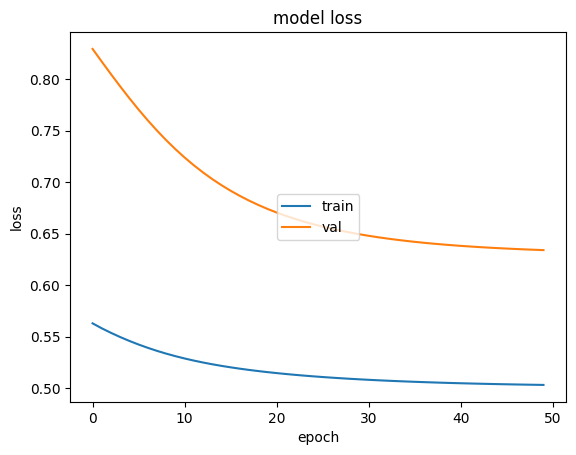

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [20]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = xC_train,
    y = yC_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = xC_val,
    y = yC_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = xC_test,
    y = yC_test
)

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4791  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6423 
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.9822


1.8689780235290527

In [21]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccionC_val = prediccion_fun(xC_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = consumoScaled.values , n=entrenamiento)
prediccionC_test = prediccion_fun(xC_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = consumoScaled.values , n=entrenamiento+val_prueba)

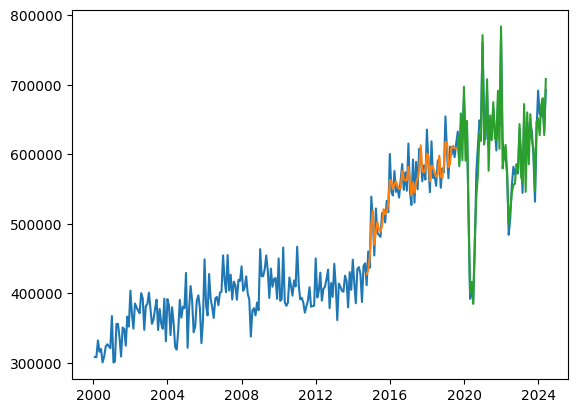

In [22]:
df_val = pd.DataFrame(prediccionC_val,index=consumoScaled[(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccionC_test,index=consumoScaled[entrenamiento+len(df_val):len(consumoScaled)].index)


plt.plot(consumoScaled)
plt.plot(df_val)
plt.plot(df_test)



## Importacion


In [23]:
importacion["Gasolina superior"] = importacion["Gasolina superior"].astype(str)
importacion["Gasolina superior"] = importacion["Gasolina superior"].apply(lambda x: x.replace(',', '')).astype(float)
importacion.head()

,Fecha,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petróleo,Gasolina de aviación,...,Naftas,Petcoke,Petróleo crudo,Solventes,Butano,Diesel alto azufre,MTBE,Orimulsión,Petróleo reconstituido,Total importación
0,1-Jan,0,"27,748.99","214,581.84",0.0,0,0,0,"194,065.74",820,...,0.0,0,0,0,0.0,"566,101.99","8,402.00",0,"715,344.00","2,312,639.05"
1,1-Feb,0,"7,503.57","294,609.00",0.0,0,0,0,"170,703.38","3,054.00",...,0.0,0,0,0,0.0,"489,525.80",0,0,"370,166.00","1,769,208.76"
2,1-Mar,0,"26,304.32","315,263.80",0.0,0,0,0,"161,837.37",677,...,0.0,0,0,0,0.0,"575,559.68",0,0,"360,530.00","1,945,770.26"
3,1-Apr,0,"7,885.89","205,653.00",0.0,0,0,0,"163,048.64","3,399.00",...,0.0,0,0,0,0.0,"437,745.42","8,184.00",0,"359,527.00","1,623,637.76"
4,1-May,0,"8,443.16","278,371.30",0.0,0,0,0,"171,518.86",585,...,0.0,0,0,0,0.0,"552,609.13","12,680.00",0,"723,346.00","2,262,726.64"


In [24]:
importacion['Fecha'] = pd.to_datetime(importacion['Fecha'], format='%d-%b', errors='coerce')
importacion.set_index('Fecha', inplace=True)

### Series de tiempo

In [25]:
importacion_superior_resampled = importacion['Gasolina superior'].resample('M').mean()

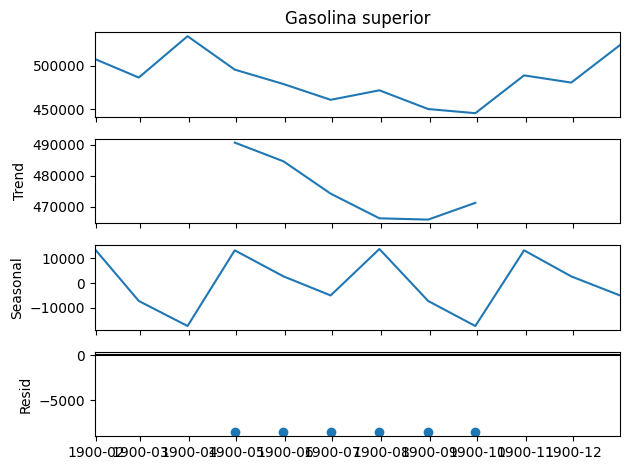

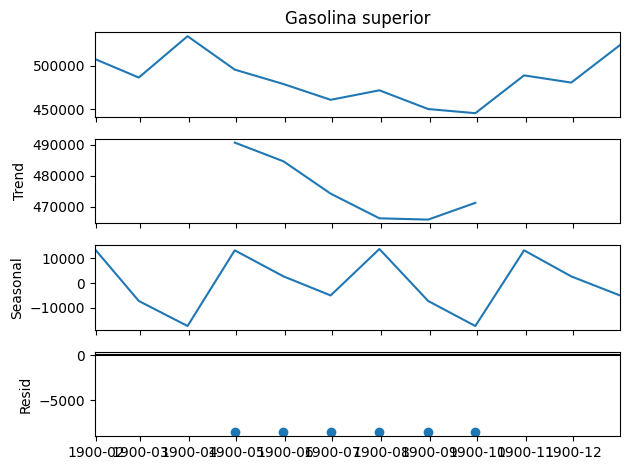

In [26]:
resultado_superior_i = seasonal_decompose(importacion_superior_resampled.dropna(), period=6)
resultado_superior_i.plot()

### LSTM

In [27]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(importacion_superior_resampled, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba        -1.851236
p-value                       0.355337
# de retardos usados          0.000000
# de observaciones usadas    11.000000
Critical Value (1%)          -4.223238
Critical Value (5%)          -3.189369
Critical Value (10%)         -2.729839
dtype: float64


In [28]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
importacion_diff = importacion_superior_resampled.diff()
importacion_diff.fillna(0,inplace=True)
dfTest = adfuller(importacion_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba        -4.125597
p-value                       0.000878
# de retardos usados          0.000000
# de observaciones usadas    11.000000
Critical Value (1%)          -4.223238
Critical Value (5%)          -3.189369
Critical Value (10%)         -2.729839
dtype: float64


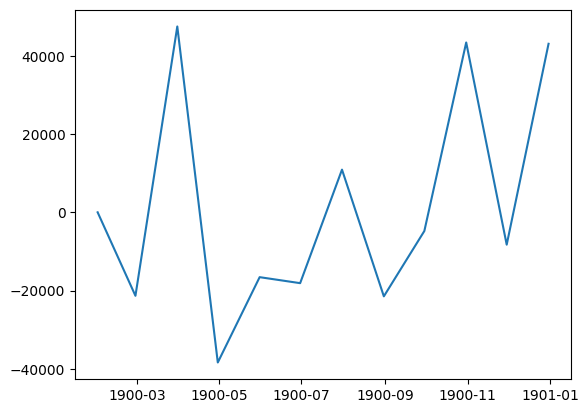

In [29]:
plt.plot(importacion_diff)

In [30]:
scaler = StandardScaler()
# Convertir la serie a un array de NumPy
importacion_diff_array = importacion_diff.values

# Reshape a 2D
importacion_diff_array = importacion_diff_array.reshape(-1, 1)
data_i = scaler.fit_transform(importacion_diff_array)

In [31]:
entrenamiento_i = round(0.6*len(data_i))
val_prueba_i = round(0.2*len(data_i))
test = data_i[(entrenamiento_i+val_prueba_i)-1:]
validation = data_i[(entrenamiento_i):entrenamiento_i+val_prueba_i+1]
train = data_i[0:entrenamiento_i]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

4

In [32]:
xi_train,yi_train = supervisada(train)
xi_val,yi_val = supervisada(validation)
xi_test,yi_test = supervisada(test)


In [33]:
xi_train = np.reshape(xi_train,(xi_train.shape[0],1,1))
xi_val = np.reshape(xi_val, (xi_val.shape[0],1,1))
xi_test = np.reshape(xi_test, (xi_test.shape[0],1,1))
len(xi_val)

2

In [34]:
epocas = 50
history_i= modelo1.fit(
    x = xi_train,
    y = yi_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (xi_val,yi_val),
    verbose=1
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6527 - val_loss: 1.0157
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6502 - val_loss: 1.0193
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6477 - val_loss: 1.0229
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6454 - val_loss: 1.0266
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6431 - val_loss: 1.0302
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6408 - val_loss: 1.0338
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6386 - val_loss: 1.0374
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6365 - val_loss: 1.0410
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6344 - val_loss: 1.0446
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6324 - val_loss: 1.0482
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6304 - val_loss: 1.0518
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6285 - val_loss: 1.0553
Epoch 13/5

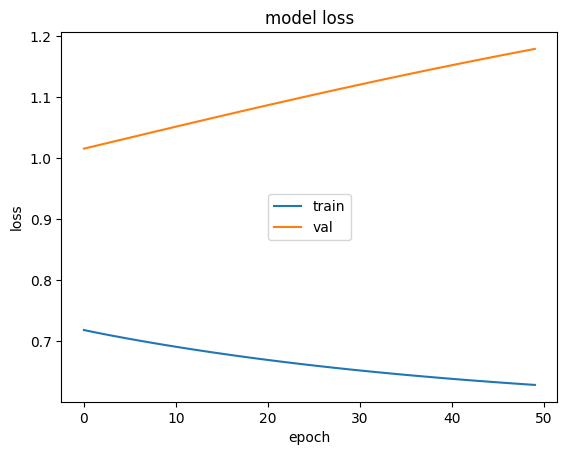

In [35]:
plt.plot(history_i.history['loss'])
plt.plot(history_i.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [36]:
prediccioni_val = []

prediccioni_val = prediccion_fun(xi_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series =importacion_superior_resampled.values , n=entrenamiento_i)
prediccioni_test = prediccion_fun(xi_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = importacion_superior_resampled.values , n=entrenamiento_i+val_prueba_i)

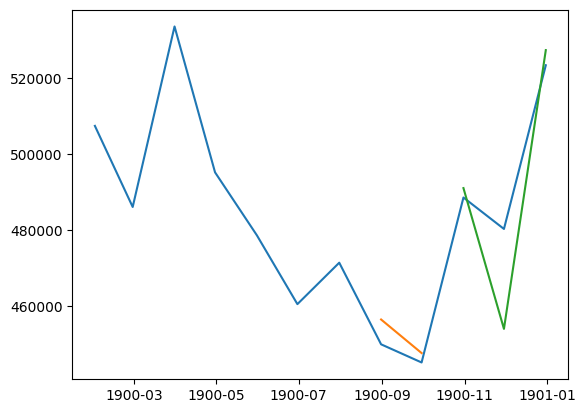

In [37]:
df_val_i = pd.DataFrame(prediccioni_val, index=importacion_superior_resampled[(entrenamiento_i):entrenamiento_i+val_prueba_i].index)
df_test_i = pd.DataFrame(prediccioni_test, index=importacion_superior_resampled[entrenamiento_i+len(df_val_i):len(importacion_superior_resampled)].index)


plt.plot(importacion_superior_resampled)
plt.plot(df_val_i)
plt.plot(df_test_i)


## Precios

In [38]:
PreciosPromedio.head()

,FECHA,Tipo de cambio,Superior,Regular,Diesel,Bunker,Glp Cilindro 25Lbs.,Unnamed: 7
0,1-Jan-21,7.79382,21.91,21.11,17.61,13.40,99.0,3.96
1,2-Jan-21,7.79382,21.91,21.11,17.61,13.40,99.0,3.96
2,3-Jan-21,7.79382,21.91,21.11,17.61,13.40,99.0,3.96
3,4-Jan-21,7.79417,21.91,21.11,17.61,13.45,99.0,3.96
4,5-Jan-21,7.79369,21.91,21.11,17.61,13.45,99.0,3.96


In [39]:
#PreciosPromedio['FECHA'] = pd.to_datetime(PreciosPromedio['FECHA'], format='%d-%b-%Y', errors='coerce')
PreciosPromedio['FECHA'] = pd.to_datetime(PreciosPromedio['FECHA'], errors='coerce')

<ipython-input-39-e3779208609a>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  PreciosPromedio['FECHA'] = pd.to_datetime(PreciosPromedio['FECHA'], errors='coerce')


In [40]:
PreciosPromedio.set_index('FECHA', inplace=True)

### Serie de tiempo

In [41]:
precio_superior_resampled = PreciosPromedio['Superior'].resample('M').mean()

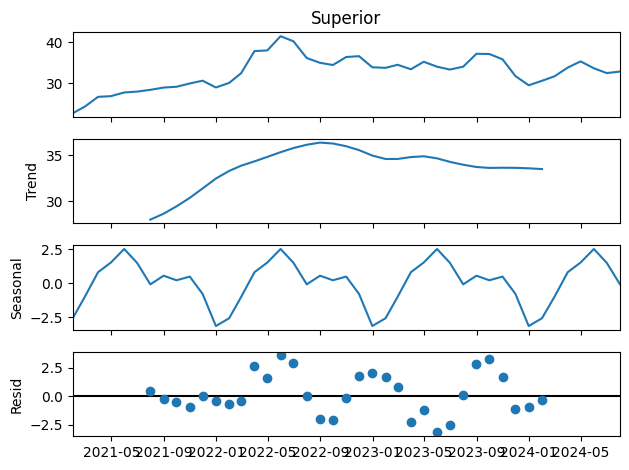

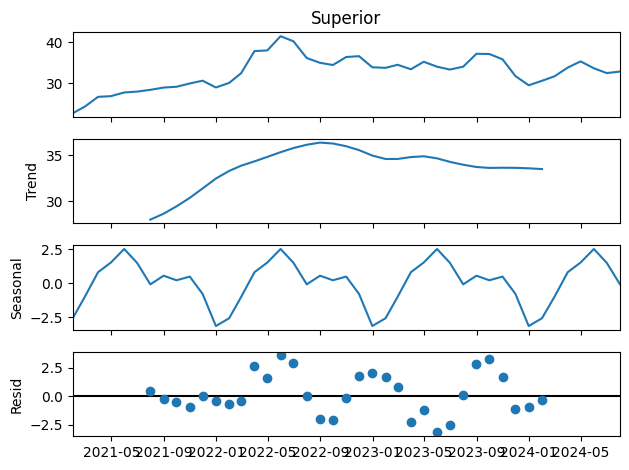

In [42]:
resultado_superiorP = seasonal_decompose(precio_superior_resampled.dropna())
resultado_superiorP.plot()


In [43]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(precio_superior_resampled, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba        -2.777253
p-value                       0.061597
# de retardos usados          1.000000
# de observaciones usadas    41.000000
Critical Value (1%)          -3.600983
Critical Value (5%)          -2.935135
Critical Value (10%)         -2.605963
dtype: float64


In [44]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
precio_diff = precio_superior_resampled.diff()
precio_diff.fillna(0,inplace=True)
dfTest = adfuller(precio_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba        -4.843615
p-value                       0.000045
# de retardos usados          0.000000
# de observaciones usadas    42.000000
Critical Value (1%)          -3.596636
Critical Value (5%)          -2.933297
Critical Value (10%)         -2.604991
dtype: float64


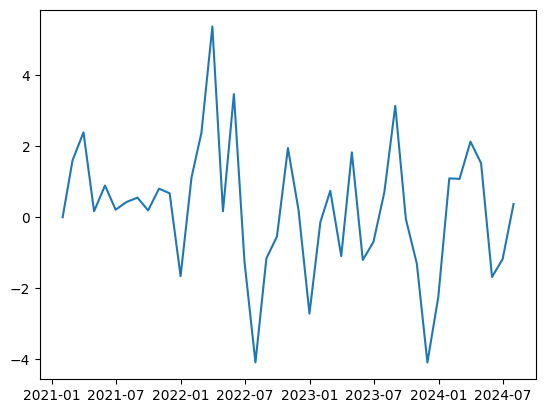

In [45]:
plt.plot(precio_diff)

In [46]:
scaler = StandardScaler()
# Convertir la serie a un array de NumPy
precio_diff_array = precio_diff.values

# Reshape a 2D
precio_diff_array = precio_diff_array.reshape(-1, 1)
data_p = scaler.fit_transform(precio_diff_array)

In [47]:
entrenamiento_p = round(0.6*len(data_p))
val_prueba_p = round(0.2*len(data_p))
test = data_p[(entrenamiento_p+val_prueba_p)-1:]
validation = data_p[(entrenamiento_p):entrenamiento_p+val_prueba_p+1]
train = data_p[0:entrenamiento_p]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

9

In [48]:
xp_train,yp_train = supervisada(train)
xp_val,yp_val = supervisada(validation)
xp_test,yp_test = supervisada(test)

In [49]:
xp_train = np.reshape(xp_train,(xp_train.shape[0],1,1))
xp_val = np.reshape(xp_val, (xp_val.shape[0],1,1))
xp_test = np.reshape(xp_test, (xp_test.shape[0],1,1))
len(xp_val)

9

In [50]:
epocas = 50
history_p= modelo1.fit(
    x = xp_train,
    y = yp_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (xp_val,yp_val),
    verbose=1
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0901 - val_loss: 1.5918
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0652 - val_loss: 1.5880
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0442 - val_loss: 1.5846
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0245 - val_loss: 1.5814
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0057 - val_loss: 1.5786
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9878 - val_loss: 1.5759
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9708 - val_loss: 1.5735
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9546 - val_loss: 1.5713
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9392 - val_loss: 1.5693
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9246 - val_loss: 1.5674
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9106 - val_loss: 1.5657
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8973 - val_lo

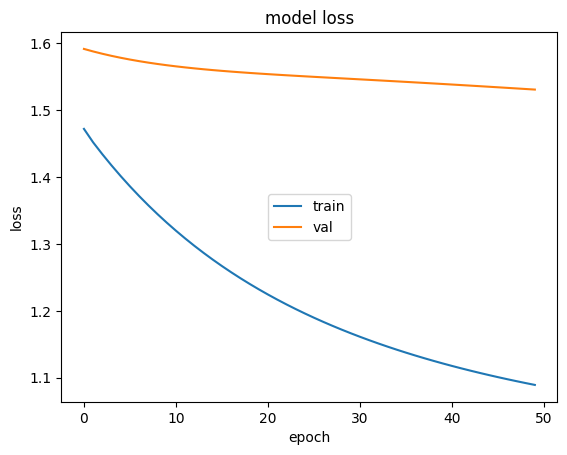

In [51]:
plt.plot(history_p.history['loss'])
plt.plot(history_p.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [52]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = xp_train,
    y = yp_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = xp_val,
    y = yp_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = xp_test,
    y = yp_test
)

Pérdida en Entrenamiento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0859
Pérdida en Validación
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.5310
Pérdida en Prueba
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7809


0.780897855758667

In [53]:
prediccionp_val = []

prediccionp_val = prediccion_fun(xp_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series =precio_superior_resampled.values , n=entrenamiento_p)
prediccionp_test = prediccion_fun(xp_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = precio_superior_resampled.values , n=entrenamiento_p+val_prueba_p)

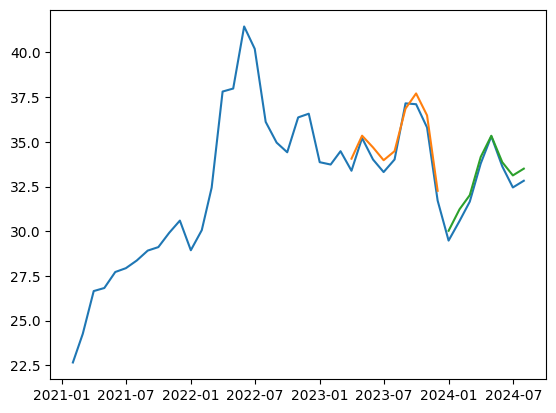

In [54]:
df_val_p = pd.DataFrame(prediccionp_val,index=precio_superior_resampled[(entrenamiento_p):entrenamiento_p+val_prueba_p].index)
df_test_p = pd.DataFrame(prediccionp_test,index=precio_superior_resampled[entrenamiento_p+len(df_val_p):len(precio_superior_resampled)].index)


plt.plot(precio_superior_resampled)
plt.plot(df_val_p)
plt.plot(df_test_p)


In [55]:
consumo = pd.read_csv('CONSUMO.csv')
importacion=pd.read_csv('IMPORTACION.csv')
PreciosPromedio=pd.read_csv('PreciosPromedio.csv')

# Mostrar los nombres de las columnas para verificar
print("Columnas en consumo_df:", consumo.columns)
print("Columnas en importacion_df:", importacion.columns)
print("Columnas en precios_df:", PreciosPromedio.columns)

Columnas en consumo_df: Index(['Fecha', 'Aceites lubricantes', 'Asfalto', 'Bunker', 'Ceras',
       'Combustible turbo jet', 'Diesel bajo azufre',
       'Diesel ultra bajo azufre', 'Gas licuado de petróleo',
       'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior',
       'Grasas lubricantes', 'Kerosina', 'Mezclas\noleosas', 'Naftas',
       'PetCoke', 'Petróleo crudo', 'Solventes', 'Butano',
       'Diesel alto azufre', 'Orimulsión', 'Total'],
      dtype='object')
Columnas en importacion_df: Index(['Fecha', 'Aceites lubricantes', 'Asfalto ', 'Bunker', 'Ceras',
       'Combustible turbo jet', 'Diesel bajo azufre',
       'Diesel ultra bajo azufre', 'Gas licuado de petróleo',
       'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior',
       'Grasas lubricantes', 'Kerosina', 'Mezclas oleosas', 'Naftas',
       'Petcoke', 'Petróleo crudo', 'Solventes', 'Butano',
       'Diesel alto azufre', 'MTBE', 'Orimulsión', 'Petróleo reconstituido',
       'Total importac

# Modelo 2

In [56]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [57]:
#Cargar los datos de nuevo
consumo = pd.read_csv('CONSUMO.csv')
importacion = pd.read_csv('IMPORTACION.csv')
PreciosPromedio = pd.read_csv('PreciosPromedio.csv')

In [58]:
#Función para limpiar los datos
def cleanData(df, column):
    df[column] = df[column].astype(str)  # Convertir a string
    df[column] = df[column].str.replace(',', '')  # Reemplazar comas
    df[column] = pd.to_numeric(df[column], errors='coerce')  # Convertir a numérico
    df.dropna(subset=[column], inplace=True)  # Eliminar filas con NaN
    return df

In [59]:
#Limpiar los datos
consumo = cleanData(consumo, 'Total')
importacion = cleanData(importacion, 'Total importación')
PreciosPromedio = cleanData(PreciosPromedio, 'Superior')

In [60]:
#Preprocesar los datos
scaler = MinMaxScaler(feature_range=(0, 1))

In [61]:
#Procesar cada serie
consumoData = consumo['Total'].values.reshape(-1, 1)
importacionData = importacion['Total importación'].values.reshape(-1, 1)
preciosPromedioData = PreciosPromedio['Superior'].values.reshape(-1, 1)

consumoScaled = scaler.fit_transform(consumoData)
importacionScaled = scaler.fit_transform(importacionData)
preciosPromedioScaled = scaler.fit_transform(preciosPromedioData)

In [62]:
#Dividir en conjuntos de entrenamiento y prueba
trainSize = int(len(consumoScaled) * 0.75)
testSize = len(consumoScaled) - trainSize
consumoTrain, consumo_test = consumoScaled[0:trainSize, :], consumoScaled[trainSize:len(consumoScaled), :]

trainSize = int(len(importacionScaled) * 0.75)
testSize = len(importacionScaled) - trainSize
importacionTrain, importacion_test = importacionScaled[0:trainSize, :], importacionScaled[trainSize:len(importacionScaled), :]

trainSize = int(len(preciosPromedioScaled) * 0.75)
testSize = len(preciosPromedioScaled) - trainSize
precioTrain, precio_test = preciosPromedioScaled[0:trainSize, :], preciosPromedioScaled[trainSize:len(preciosPromedioScaled), :]

In [63]:
#Función para crear conjuntos de datos para LSTM
def createDataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [64]:
#Crear conjuntos de datos para LSTM
timeStep = 10

X_train_con, y_train_con = createDataset(consumoTrain, timeStep)
X_test_con, y_test_con = createDataset(consumo_test, timeStep)

X_train_imp, y_train_imp = createDataset(importacionTrain, timeStep)
X_test_imp, y_test_imp = createDataset(importacion_test, timeStep)

X_train_pre, y_train_pre = createDataset(precioTrain, timeStep)
X_test_pre, y_test_pre = createDataset(precio_test, timeStep)

In [65]:
#Redimensionar la entrada para LSTM
X_train_con = X_train_con.reshape(X_train_con.shape[0], X_train_con.shape[1], 1)
X_test_con = X_test_con.reshape(X_test_con.shape[0], X_test_con.shape[1], 1)

X_train_imp = X_train_imp.reshape(X_train_imp.shape[0], X_train_imp.shape[1], 1)
X_test_imp = X_test_imp.reshape(X_test_imp.shape[0], X_test_imp.shape[1], 1)

X_train_pre = X_train_pre.reshape(X_train_pre.shape[0], X_train_pre.shape[1], 1)
X_test_pre = X_test_pre.reshape(X_test_pre.shape[0], X_test_pre.shape[1], 1)

In [66]:
#Función para crear y compilar el modelo LSTM
def createLSTMmodel():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(timeStep, 1)),
        tf.keras.layers.LSTM(50, return_sequences=False),
        tf.keras.layers.Dense(25),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## Creación y entrenamiento de los modelos

In [67]:
#Crear y entrenar los modelos
consumoModel = createLSTMmodel()
importacionModel = createLSTMmodel()
preciosPromedioModel = createLSTMmodel()

consumoModel.fit(X_train_con, y_train_con, batch_size=1, epochs=1)
importacionModel.fit(X_train_imp, y_train_imp, batch_size=1, epochs=1)
preciosPromedioModel.fit(X_train_pre, y_train_pre, batch_size=1, epochs=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0083
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0181
967/967 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0082


In [68]:
#Hacer predicciones con los modelos
train_predict_con = consumoModel.predict(X_train_con)
test_predict_con = consumoModel.predict(X_test_con)

train_predict_imp = importacionModel.predict(X_train_imp)
test_predict_imp = importacionModel.predict(X_test_imp)

train_predict_pre = preciosPromedioModel.predict(X_train_pre)
test_predict_pre = preciosPromedioModel.predict(X_test_pre)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [69]:
#Transformar de vuelta a la escala original
train_predict_con = scaler.inverse_transform(train_predict_con)
test_predict_con = scaler.inverse_transform(test_predict_con)

train_predict_imp = scaler.inverse_transform(train_predict_imp)
test_predict_imp = scaler.inverse_transform(test_predict_imp)

train_predict_pre = scaler.inverse_transform(train_predict_pre)
test_predict_pre = scaler.inverse_transform(test_predict_pre)

## Graficar resultados

In [70]:
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

### Consumo de Combustibles

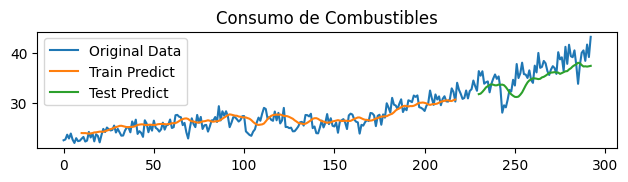

In [71]:
plt.subplot(3, 1, 1)
plt.plot(scaler.inverse_transform(consumoScaled), label='Original Data')
plt.plot(np.arange(timeStep, timeStep + len(train_predict_con)), train_predict_con, label='Train Predict')
plt.plot(np.arange(len(consumoScaled) - len(test_predict_con), len(consumoScaled)), test_predict_con, label='Test Predict')
plt.title('Consumo de Combustibles')
plt.legend()

plt.tight_layout()
plt.show()

### Importación de Combustibles

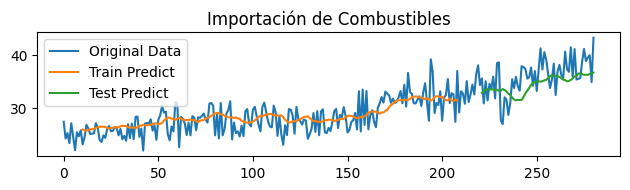

In [72]:
plt.subplot(3, 1, 2)
plt.plot(scaler.inverse_transform(importacionScaled), label='Original Data')
plt.plot(np.arange(timeStep, timeStep + len(train_predict_imp)), train_predict_imp, label='Train Predict')
plt.plot(np.arange(len(importacionScaled) - len(test_predict_imp), len(importacionScaled)), test_predict_imp, label='Test Predict')
plt.title('Importación de Combustibles')
plt.legend()

plt.tight_layout()
plt.show()

### Precios Promedios

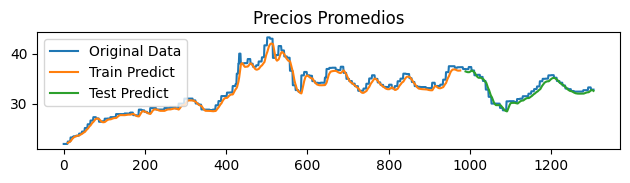

In [73]:
plt.subplot(3, 1, 3)
plt.plot(scaler.inverse_transform(preciosPromedioScaled), label='Original Data')
plt.plot(np.arange(timeStep, timeStep + len(train_predict_pre)), train_predict_pre, label='Train Predict')
plt.plot(np.arange(len(preciosPromedioScaled) - len(test_predict_pre), len(preciosPromedioScaled)), test_predict_pre, label='Test Predict')
plt.title('Precios Promedios')
plt.legend()

plt.tight_layout()
plt.show()

# Tuneo de parámetros

In [74]:
time_step = 12
#Definir la función para crear el modelo con hiperparámetros variables
def createLSTMmodelHyperparameters(units=3, learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(units, return_sequences=True, input_shape=(time_step, 1)),
        tf.keras.layers.LSTM(units, return_sequences=False),
        tf.keras.layers.Dense(25),
        tf.keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

#Función para ajustar un parámetro a la vez
def tuneSingleParam(X_train, y_train, X_val, y_val, param_name, param_values):
    best_loss = float('inf')
    best_value = None

    for value in param_values:
        print(f"Tuning {param_name} with value {value}")

        #Crear el modelo con el valor actual del parámetro
        if param_name == 'units':
            model = createLSTMmodelHyperparameters(units=value)
        elif param_name == 'learning_rate':
            model = createLSTMmodelHyperparameters(learning_rate=value)
        elif param_name == 'batch_size':
            model = createLSTMmodelHyperparameters()
        elif param_name == 'epochs':
            model = createLSTMmodelHyperparameters()

        #Entrenar el modelo
        if param_name in ['batch_size', 'epochs']:
            model.fit(X_train, y_train, batch_size=value if param_name == 'batch_size' else 16, epochs=value if param_name == 'epochs' else 3, verbose=0)
        else:
            model.fit(X_train, y_train, batch_size=16, epochs=3, verbose=0)

        #Evaluar el modelo
        loss = model.evaluate(X_val, y_val, verbose=0)
        print(f"Validation loss: {loss}")

        #Guardar el mejor parámetro
        if loss < best_loss:
            best_loss = loss
            best_value = value

    print(f"Best {param_name}: {best_value} with loss: {best_loss}")
    return best_value

#Separar un conjunto de validación
val_size = int(len(X_train_con) * 0.2)
X_val_con, y_val_con = X_train_con[-val_size:], y_train_con[-val_size:]
X_train_con, y_train_con = X_train_con[:-val_size], y_train_con[:-val_size]

X_val_imp, y_val_imp = X_train_imp[-val_size:], y_train_imp[-val_size:]
X_train_imp, y_train_imp = X_train_imp[:-val_size], y_train_imp[:-val_size]

X_val_pre, y_val_pre = X_train_pre[-val_size:], y_train_pre[-val_size:]
X_train_pre, y_train_pre = X_train_pre[:-val_size], y_train_pre[:-val_size]

#Ajustar los parámetros uno a la vez
best_units_con = tuneSingleParam(X_train_con, y_train_con, X_val_con, y_val_con, 'units', [50, 100])
best_learning_rate_con = tuneSingleParam(X_train_con, y_train_con, X_val_con, y_val_con, 'learning_rate', [0.001, 0.01])
best_batch_size_con = tuneSingleParam(X_train_con, y_train_con, X_val_con, y_val_con, 'batch_size', [16, 32])
best_epochs_con = tuneSingleParam(X_train_con, y_train_con, X_val_con, y_val_con, 'epochs', [10, 50])

#Crear modelo con los mejores parámetros encontrados
model_con_tuned = createLSTMmodelHyperparameters(units=best_units_con, learning_rate=best_learning_rate_con)
model_con_tuned.fit(X_train_con, y_train_con, batch_size=best_batch_size_con, epochs=best_epochs_con, verbose=1)

#Repetir el proceso para los otros modelos
best_units_imp = tuneSingleParam(X_train_imp, y_train_imp, X_val_imp, y_val_imp, 'units', [50, 100])
best_learning_rate_imp = tuneSingleParam(X_train_imp, y_train_imp, X_val_imp, y_val_imp, 'learning_rate', [0.001, 0.01])
best_batch_size_imp = tuneSingleParam(X_train_imp, y_train_imp, X_val_imp, y_val_imp, 'batch_size', [16, 32])
best_epochs_imp = tuneSingleParam(X_train_imp, y_train_imp, X_val_imp, y_val_imp, 'epochs', [10, 50])

model_imp_tuned = createLSTMmodelHyperparameters(units=best_units_imp, learning_rate=best_learning_rate_imp)
model_imp_tuned.fit(X_train_imp, y_train_imp, batch_size=best_batch_size_imp, epochs=best_epochs_imp, verbose=1)

best_units_pre = tuneSingleParam(X_train_pre, y_train_pre, X_val_pre, y_val_pre, 'units', [50, 100])
best_learning_rate_pre = tuneSingleParam(X_train_pre, y_train_pre, X_val_pre, y_val_pre, 'learning_rate', [0.001, 0.01])
best_batch_size_pre = tuneSingleParam(X_train_pre, y_train_pre, X_val_pre, y_val_pre, 'batch_size', [16, 32])
best_epochs_pre = tuneSingleParam(X_train_pre, y_train_pre, X_val_pre, y_val_pre, 'epochs', [10, 50])

model_pre_tuned = createLSTMmodelHyperparameters(units=best_units_pre, learning_rate=best_learning_rate_pre)
model_pre_tuned.fit(X_train_pre, y_train_pre, batch_size=best_batch_size_pre, epochs=best_epochs_pre, verbose=1)


Tuning units with value 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 0.013983034528791904
Tuning units with value 100
Validation loss: 0.01829228363931179
Best units: 50 with loss: 0.013983034528791904
Tuning learning_rate with value 0.001
Validation loss: 0.03354274481534958
Tuning learning_rate with value 0.01


Validation loss: 0.02841249853372574
Best learning_rate: 0.01 with loss: 0.02841249853372574
Tuning batch_size with value 16


Validation loss: 0.020303862169384956
Tuning batch_size with value 32
Validation loss: 0.02520676888525486
Best batch_size: 16 with loss: 0.020303862169384956
Tuning epochs with value 10
Validation loss: 0.027901550754904747
Tuning epochs with value 50
Validation loss: 0.018515029922127724
Best epochs: 50 with loss: 0.018515029922127724
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0230
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0052
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0043
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0052
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0048
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0037
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035


# Comparación de los modelos entre ellos

El Modelo 1 tiene una arquitectura básica que incluye solo una capa LSTM con una unidad y mostró un rendimiento limitado. Aunque la pérdida en el conjunto de entrenamiento disminuyó consistentemente a lo largo de las 50 épocas, la pérdida en el conjunto de validación se mantuvo relativamente alta. Esto sugiere que el modelo tenía dificultades para capturar los patrones subyacentes en los datos, lo que podría indicar una tendencia al subajuste. El modelo no tenía la capacidad suficiente para aprender las complejidades presentes en las series de tiempo, especialmente en conjuntos de datos con fluctuaciones más pronunciadas, como la importación de combustibles y los precios.

Por otro lado, el Modelo 2 tiene una arquitectura que incluye dos capas LSTM con 50 unidades cada una y capas densas adicionales y mostró un rendimiento mucho mejor desde el principio. Incluso después de solo una época de entrenamiento, la pérdida en el conjunto de validación fue significativamente menor en comparación con el Modelo 1. Esto indica que el Modelo 2 fue capaz de generalizar mejor y capturar patrones más complejos en los datos, evitando tanto el subajuste como el sobreajuste, algo que se reflejó en las predicciones mucho más precisas en todos los conjuntos de datos.

En términos de precisión, el Modelo 2 superó ampliamente al Modelo 1, ya que las predicciones se acercaron mucho más a los valores reales en todas las series de tiempo analizadas. Por lo que en conclusión, el Modelo 2 es superior al Modelo 1 en términos de precisión y capacidad de generalización. Su arquitectura más compleja lo hace más adecuado para manejar series de tiempo con tendencias y variaciones significativas, lo que lo convierte en la opción preferida para tareas de pronóstico en los conjuntos de datos que se han analizado.

# Predicción de cada serie con el mejor modelo (Modelo 2)

In [75]:
#Predicción para la serie de tiempo de consumo
prediccion_con = model_con_tuned.predict(X_test_con)
prediccion_con = scaler.inverse_transform(prediccion_con)  #Volver a la escala original

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


In [76]:
#Predicción para la serie de tiempo de importación
prediccion_imp = model_imp_tuned.predict(X_test_imp)
prediccion_imp = scaler.inverse_transform(prediccion_imp)  #Volver a la escala original

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step


In [77]:
#Predicción para la serie de tiempo de precios
prediccion_pre = model_pre_tuned.predict(X_test_pre)
prediccion_pre = scaler.inverse_transform(prediccion_pre)  #Volver a la escala original

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [78]:
#Graficar los resultados para cada serie de tiempo
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

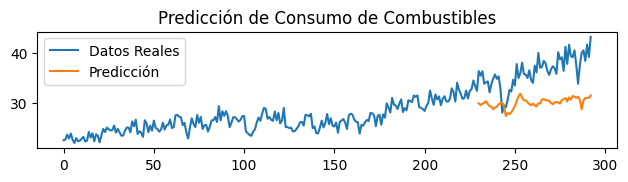

In [79]:
#Consumo
plt.subplot(3, 1, 1)
plt.plot(scaler.inverse_transform(consumoScaled), label='Datos Reales')
plt.plot(np.arange(len(consumoScaled) - len(prediccion_con), len(consumoScaled)), prediccion_con, label='Predicción')
plt.title('Predicción de Consumo de Combustibles')
plt.legend()

plt.tight_layout()
plt.show()

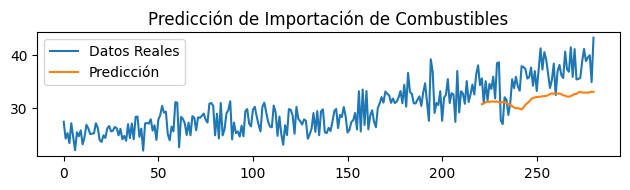

In [80]:
#Importación
plt.subplot(3, 1, 2)
plt.plot(scaler.inverse_transform(importacionScaled), label='Datos Reales')
plt.plot(np.arange(len(importacionScaled) - len(prediccion_imp), len(importacionScaled)), prediccion_imp, label='Predicción')
plt.title('Predicción de Importación de Combustibles')
plt.legend()

plt.tight_layout()
plt.show()

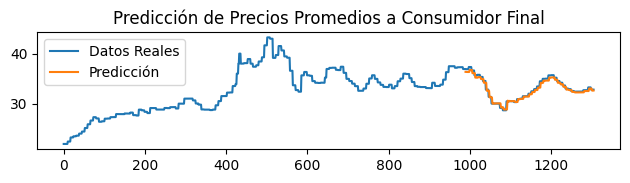

In [81]:
#Precios
plt.subplot(3, 1, 3)
plt.plot(scaler.inverse_transform(preciosPromedioScaled), label='Datos Reales')
plt.plot(np.arange(len(preciosPromedioScaled) - len(prediccion_pre), len(preciosPromedioScaled)), prediccion_pre, label='Predicción')
plt.title('Predicción de Precios Promedios a Consumidor Final')
plt.legend()

plt.tight_layout()
plt.show()


# Comparación de algoritmos
**Modelo ARIMA** En el laboratorio anterior, ([Link al repositorio aquí](https://github.com/SofiLam13/Lab2-DS-.git)) vemos que para cada una de las series de tiempo, el modelo 1 de ARIMA es más adecuado, pues tienen un menor AIC y BIC. Entonces, para compararlo con el Modelo 2 de LSTM, tomamos en cuenta los MSE de cada serie de tiempo y el respectivo modelo.


1.   Consumo de Gasolina superior: 4115589481.757091
2.   Importación de gasolina superior: 27348464194.552948
3.   Precio de gasolina superior: 23.221455317245677

Ahora calculamos los MSE del Modelo 2 de LSTM:



In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
#Consumo
prediccion_con_inversa = scaler.inverse_transform(prediccion_con.reshape(-1, 1))
consumo_real_inversa = scaler.inverse_transform(consumoScaled)
consumo_real_alineado = consumo_real_inversa[-len(prediccion_con):]
mse = mean_squared_error(consumo_real_alineado, prediccion_con_inversa)
print("Consumo")
print(f'MSE: {mse}')

#Importación
print("Importación")

prediccion_imp_inversa = scaler.inverse_transform(prediccion_imp.reshape(-1, 1))
importacion_real_inversa = scaler.inverse_transform(importacionScaled)
importacion_real_alineado = importacion_real_inversa[-len(prediccion_imp):]
mse_importacion = mean_squared_error(importacion_real_alineado, prediccion_imp_inversa)
print(f'MSE: {mse_importacion}')

#Precio
print("Precio")
prediccion_pre_inversa = scaler.inverse_transform(prediccion_pre.reshape(-1, 1))
precios_real_inversa = scaler.inverse_transform(preciosPromedioScaled)
precios_real_alineado = precios_real_inversa[-len(prediccion_pre):]
mse_precios = mean_squared_error(precios_real_alineado, prediccion_pre_inversa)
print(f'MSE: {mse_precios}')


Consumo
MSE: 391960.788738516
Importación
MSE: 439269.49088052
Precio
MSE: 473926.6965036833


Entonces, tenemos que el MSE del modelo 2 LSTM de cada serie de tiempo es:
1.   Consumo de Gasolina superior: 391960.788738516
2.   Importación de gasolina superior: 439269.49088052
3.   Precio de gasolina superior: 473926.6965036833

De esto podemos concluir que para la serie de tiempo del consumo de gasolina superior, es mejor el modelo seleccionado de LSTM, pues tiene un MSE significativamente menor, lo que indica que es mucho más preciso para predecir el consumo.

De igual manera, para la serie de tiempo de importación de gasolina superior, es mejor el modelo seleccionado de LSTM, ya que, igualmente, tiene un MSE mucho menor, lo que sugiere que es más preciso para predecir la importación de gasolina superior.

Y por último, para la serie de tiempo de los precios de gasolina es mejor el modelo seleccionado de los modelos ARIMA, ya que tiene un MSE mucho menor, lo que indica que es más preciso.

Por lo que podemos concluir que depende de los datos y la serie de tiempo con la que se esté trabajando se elige el modelo a utilizar, y uno de los criterios que nos ayudan a elegir este modelo es el MSE.